# **Initialisation**
Initialisation de la base de données spark

In [ ]:
import os
import findspark

findspark.init()

import spark


In [ ]:
import configparser

config = configparser.ConfigParser()

In [ ]:
from pyspark.sql import SparkSession
from pyspark.sql.functions import *

spark = SparkSession.builder.master("local").appName("Import").getOrCreate()

# **Extraction**
Premier regard sur la base de données 

Extraction des données pertinents via select(). 

In [ ]:
df = spark.read.option("multiline","true").json("/Users/nicolassigal/Desktop/Scolaire/ENSTA/3A/ASI322/CVE_Analysis/src/nvdcve-1.1-2022.json")
df = df.select(explode(col("CVE_Items")))
df = df.select("col.publishedDate","col.cve.CVE_data_meta.*","col.cve.description.description_data.value","col.impact.baseMetricV3.cvssV3.*").drop("version").drop("vectorString")

json_files = os.listdir("/Users/nicolassigal/Desktop/Scolaire/ENSTA/3A/ASI322/CVE_Analysis/src/")
for json in json_files:
      if json_files != 'nvdcve-1.1-2022.json' :
            print("Importing", json,"...")
            df_temp = spark.read.option("multiline","true").json("/Users/nicolassigal/Desktop/Scolaire/ENSTA/3A/ASI322/CVE_Analysis/src/"+json)
            df_temp = df_temp.select(explode(col("CVE_Items")))
            df_temp = df_temp.select("col.publishedDate","col.cve.CVE_data_meta.*","col.cve.description.description_data.value","col.impact.baseMetricV3.cvssV3.*").drop("version").drop("vectorString")
            df = df.union(df_temp)

df2 = df.withColumnRenamed("publishedDate","date")
df2 = df2.withColumn("date",df2.date[0:7])
df3 = df2.groupBy("date").count()
df3 = df3.orderBy("date")

print("Columns : ",df2.columns)
df.printSchema()

Affichage des premières lignes et du nombre de samples à disposition pour se faire une idée.

In [ ]:
print("Number of available rows : ", df2.count())
df2.show(5)

Essai de la fonction tail pour récupérer des données. Pas idéal. La fonction "collect()" semble bien plus adaptée.

In [ ]:
print(df2.tail(1))

# Représentation graphique
Tentative de plot.

In [ ]:
import pandas as pd
pandasDF2 = df2.toPandas()
pandasDF3 = df3.toPandas()
print(pandasDF2.columns)

print(pandasDF2.shape[0])

pandasDF2 = pandasDF2[pandasDF2['baseScore'].notna()]

print(pandasDF2.shape[0])


pandasDF2.head(3)

In [ ]:
target_column = "baseScore"
target = pandasDF2[target_column]

categorical_columns = [ "attackComplexity",
                        "attackVector",
                        "availabilityImpact",
                        "confidentialityImpact",
                        "integrityImpact",
                        "privilegesRequired",
                        "scope",
                        "userInteraction"]

data = pandasDF2[categorical_columns]

def test(list):
      return list[0]

test_column = pandasDF2["value"].apply(test)

Affichage des types des différentes colonnes

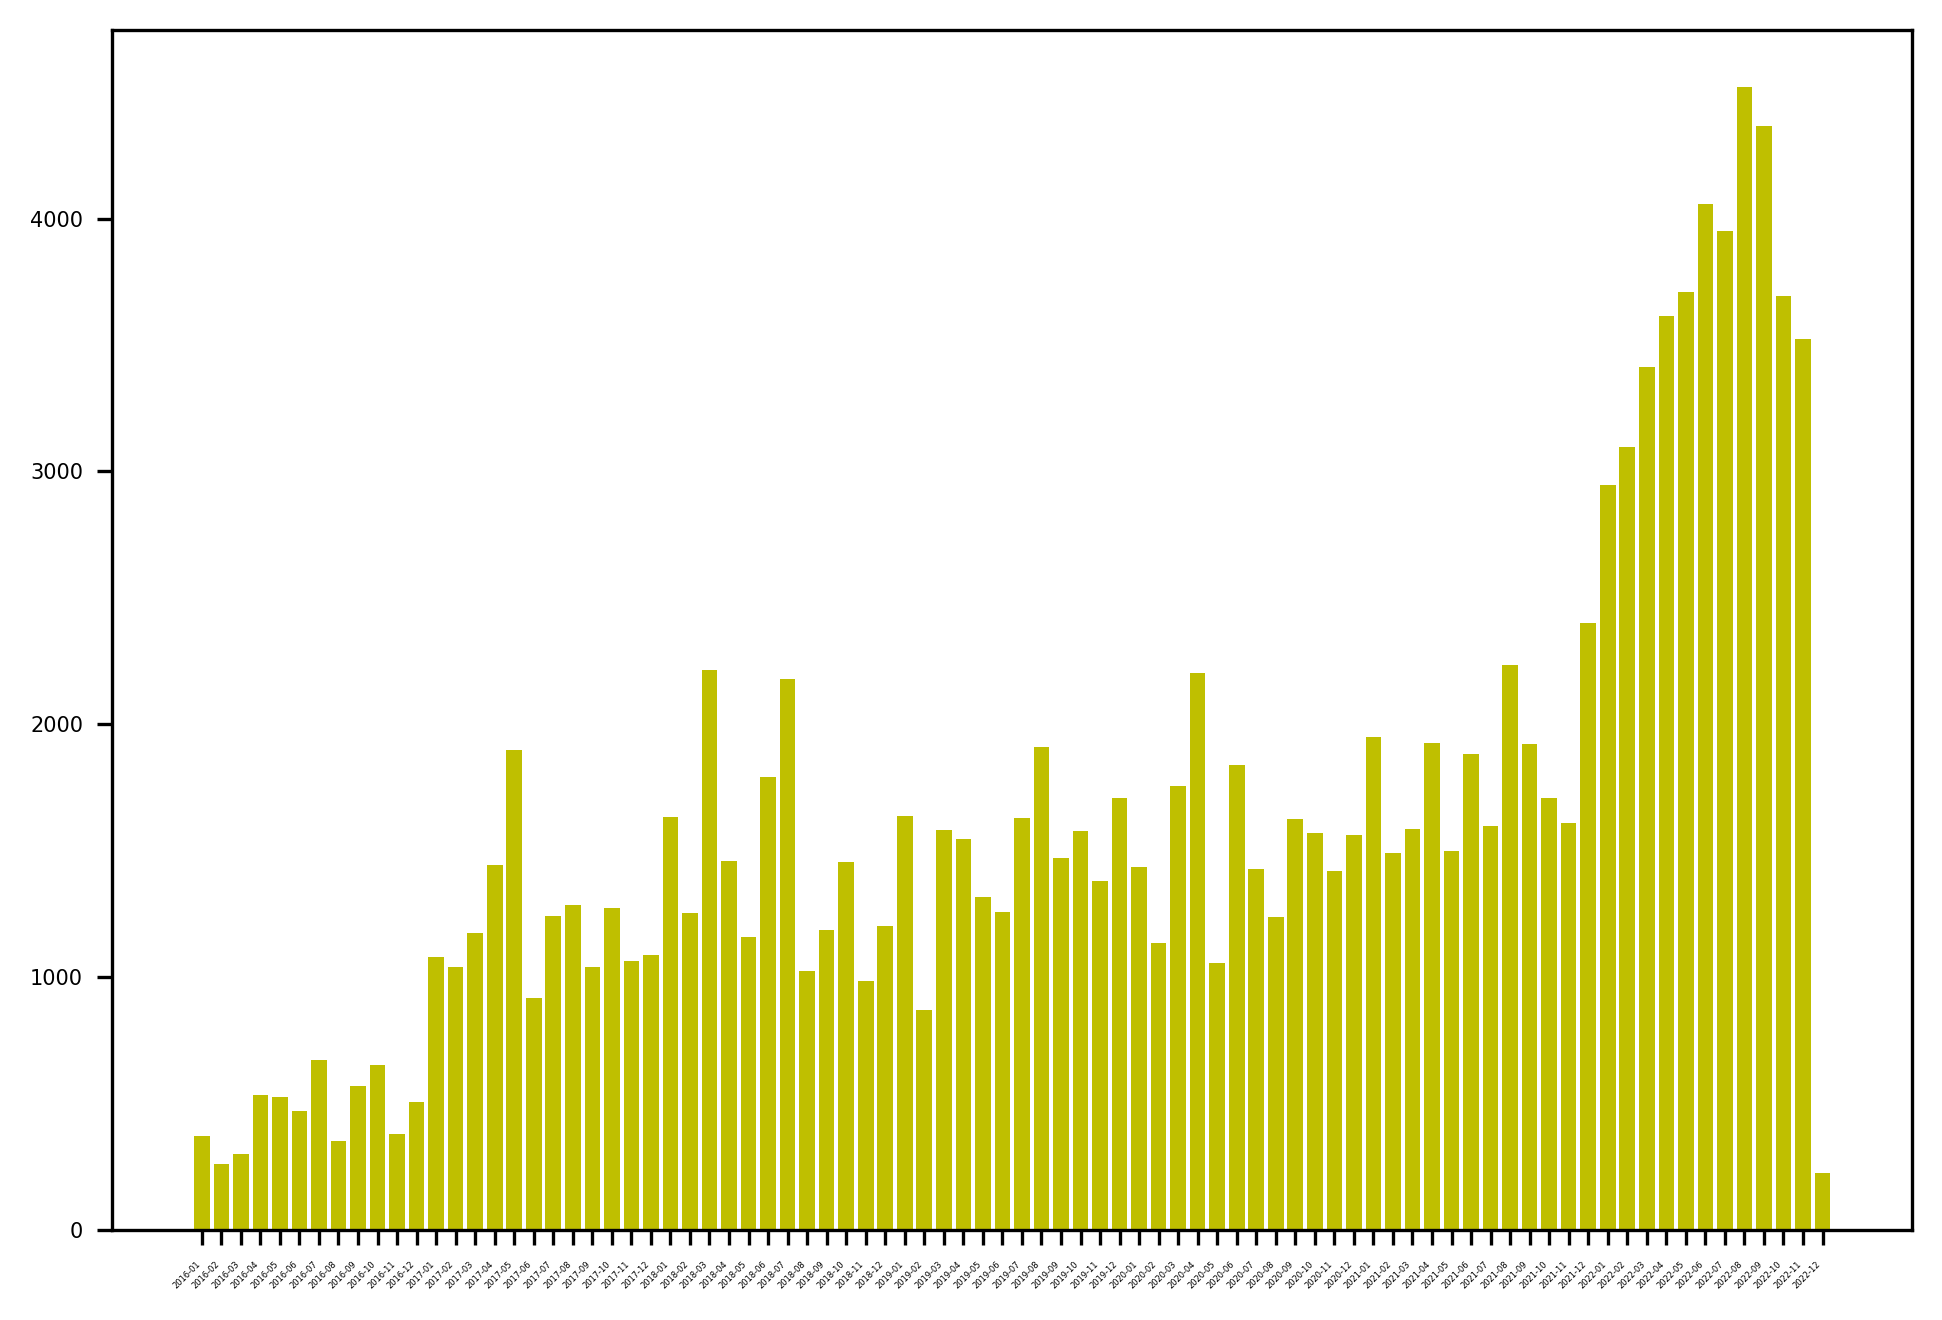

In [37]:
import numpy as np
import matplotlib.pyplot as plt

dates = pandasDF3["date"]
count = pandasDF3["count"]
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
ax.bar(dates,count,color='y')

plt.xticks(rotation=45, ha="right")
plt.rc('xtick', labelsize=3)
plt.rc('ytick', labelsize=5)
plt.rcParams['figure.dpi'] = 300

#pandasDF.loc[116]